In [1]:
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')

## Image Augmentation

In [2]:
url = "dataset-out"

train_datagen = ImageDataGenerator(rotation_range=10,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2, 
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip = True,
                                   rescale=1./255,
                                   )

test_datagen = ImageDataGenerator(rescale = 1./255)

batch_size = 64
img_size = (128, 128)

train_set = train_datagen.flow_from_directory(url + '/train', 
                                              class_mode='sparse',
                                              batch_size = batch_size,
                                              target_size=img_size,)

val_set = test_datagen.flow_from_directory(url + '/val',
                                           class_mode='sparse',
                                           batch_size = batch_size,
                                           target_size=img_size,)

test_set = test_datagen.flow_from_directory(url + '/test',
                                            class_mode='sparse',
                                           batch_size = batch_size,
                                           shuffle=False,
                                           target_size=img_size)

Found 2219 images belonging to 7 classes.
Found 276 images belonging to 7 classes.
Found 283 images belonging to 7 classes.


In [3]:
class_to_index = train_set.class_indices
index_to_class = {v: k for k, v in class_to_index.items()}

print(class_to_index)
print(index_to_class)

{'cardboard': 0, 'glass': 1, 'metal': 2, 'organic': 3, 'paper': 4, 'plastic': 5, 'trash': 6}
{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'organic', 4: 'paper', 5: 'plastic', 6: 'trash'}


## Base Model

In [4]:
model1 = keras.models.Sequential([
    keras.layers.Input(shape=(128,128,3)),
    keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(padding='same'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(padding='same'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'),
    keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'),
    keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(padding='same'),
    keras.layers.BatchNormalization(),

    keras.layers.Dropout(0.2),
    keras.layers.Flatten(),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(7, activation='softmax'),
])

model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        3

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(patience=2)
checkpoint = keras.callbacks.ModelCheckpoint('my_model', save_best_only=True)

hist = model1.fit(train_set, validation_data=val_set, epochs=20, callbacks=[early_stopping, checkpoint])

## Transfer Learning with MobileNetV2

In [5]:
baseModel = keras.applications.MobileNetV2(input_shape=(128, 128, 3), weights='imagenet',
                                           include_top=False)

for layers in baseModel.layers:
    layers.trainable=False

In [6]:
model = keras.models.Sequential([
    baseModel,
    keras.layers.Flatten(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(7, activation='softmax'),
])

optimizer = keras.optimizers.Adam(learning_rate=0.001)
loss = keras.losses.SparseCategoricalCrossentropy()

model.compile(optimizer=optimizer,
                        loss=loss,
                        metrics=['accuracy'])

epochs=50
callbacks = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_1 (Flatten)         (None, 20480)             0         
                                                                 
 dropout_3 (Dropout)         (None, 20480)             0         
                                                                 
 dense_3 (Dense)             (None, 64)                1310784   
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                      

In [7]:
history = model.fit(train_set, validation_data=val_set, epochs=epochs, callbacks=[callbacks])

Epoch 1/50
35/35 [==============================] - 33s 862ms/step - loss: 1.5879 - accuracy: 0.4196 - val_loss: 0.9086 - val_accuracy: 0.6594
Epoch 2/50
35/35 [==============================] - 19s 531ms/step - loss: 1.2037 - accuracy: 0.5525 - val_loss: 0.8078 - val_accuracy: 0.7174
Epoch 3/50
35/35 [==============================] - 19s 551ms/step - loss: 1.0988 - accuracy: 0.5976 - val_loss: 0.7876 - val_accuracy: 0.7319
Epoch 4/50
35/35 [==============================] - 21s 586ms/step - loss: 0.9915 - accuracy: 0.6467 - val_loss: 0.7046 - val_accuracy: 0.7101
Epoch 5/50
35/35 [==============================] - 20s 579ms/step - loss: 0.9396 - accuracy: 0.6566 - val_loss: 0.7405 - val_accuracy: 0.7210
Epoch 6/50
35/35 [==============================] - 20s 555ms/step - loss: 0.9024 - accuracy: 0.6746 - val_loss: 0.7901 - val_accuracy: 0.7355
Epoch 7/50
35/35 [==============================] - 19s 541ms/step - loss: 0.8126 - accuracy: 0.6940 - val_loss: 0.7324 - val_accuracy: 0.7681

#### Save model

In [8]:
model.save("waste_classifier_v2")

INFO:tensorflow:Assets written to: waste_classifier_v2\assets


INFO:tensorflow:Assets written to: waste_classifier_v2\assets


#### Training process evaluating

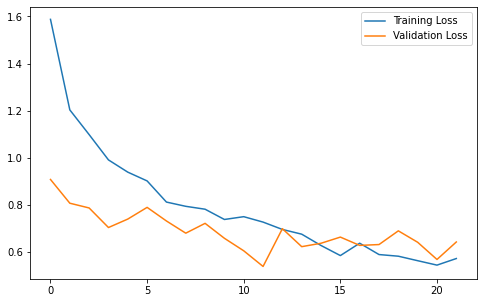

In [9]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training Loss', 'Validation Loss'])

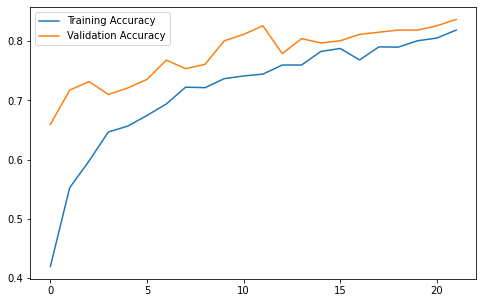

In [10]:
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training Accuracy', 'Validation Accuracy'])

## Validation Test

In [11]:
train_set = test_datagen.flow_from_directory(url + '/train',
                                            class_mode='sparse',
                                            batch_size=batch_size,
                                            shuffle=False,
                                            target_size=img_size)

validation_set = test_datagen.flow_from_directory(url + '/test',
                                            class_mode='sparse',
                                            batch_size=batch_size,
                                            shuffle=False,
                                            target_size=img_size)

Found 2219 images belonging to 7 classes.
Found 283 images belonging to 7 classes.


### Train Loss vs Validation Loss

In [12]:
print("Training loss - Accuracy")
model.evaluate(train_set)
print("Validation loss - Accuracy")
model.evaluate(val_set)
print()

Training loss - Accuracy
35/35 [==============================] - 13s 357ms/step - loss: 0.3604 - accuracy: 0.8797
Validation loss - Accuracy
5/5 [==============================] - 2s 289ms/step - loss: 0.5395 - accuracy: 0.8261



### Precision, Recall, F1-score, and Confusion Matrix

In [13]:
target_names = list(test_set.class_indices.keys())

def evaluate(y, y_pred):
    fig, ax = plt.subplots(figsize=(10, 10))

    cm = confusion_matrix(y, y_pred, normalize='all')

    cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
    
    cmp.plot(ax=ax, cmap='Blues')
    fig.show()

    print(classification_report(y, y_pred, digits=5, target_names=target_names))

#### Train set

35/35 [==============================] - 13s 346ms/step
              precision    recall  f1-score   support

   cardboard    0.92901   0.93478   0.93189       322
       glass    0.88594   0.83500   0.85972       400
       metal    0.80609   0.88720   0.84470       328
     organic    0.96482   0.96000   0.96241       200
       paper    0.90515   0.92421   0.91458       475
     plastic    0.84794   0.85455   0.85123       385
       trash    0.77647   0.60550   0.68041       109

    accuracy                        0.87968      2219
   macro avg    0.87363   0.85732   0.86356      2219
weighted avg    0.87964   0.87968   0.87869      2219



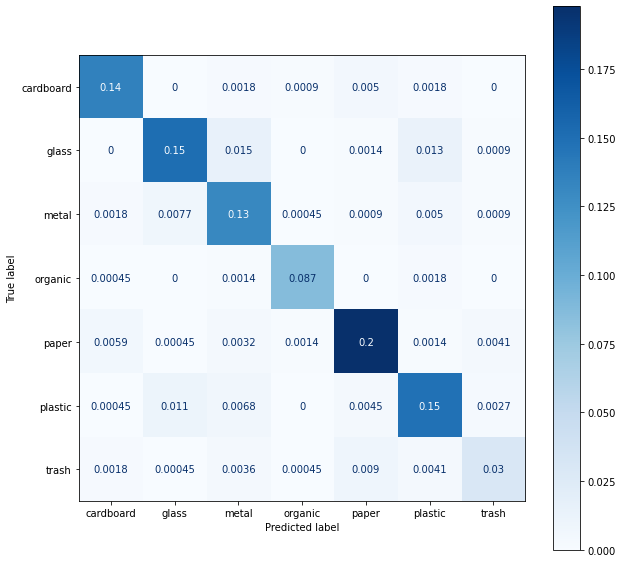

In [14]:
y = train_set.labels
y_pred = np.argmax(model.predict(train_set), axis=1)
evaluate(y, y_pred)

#### Validation set

5/5 [==============================] - 2s 310ms/step
              precision    recall  f1-score   support

   cardboard    0.09524   0.10000   0.09756        40
       glass    0.27083   0.26000   0.26531        50
       metal    0.31111   0.34146   0.32558        41
     organic    0.11538   0.12000   0.11765        25
       paper    0.27273   0.25424   0.26316        59
     plastic    0.12766   0.12500   0.12632        48
       trash    0.00000   0.00000   0.00000        13

    accuracy                        0.19928       276
   macro avg    0.17042   0.17153   0.17080       276
weighted avg    0.20004   0.19928   0.19945       276



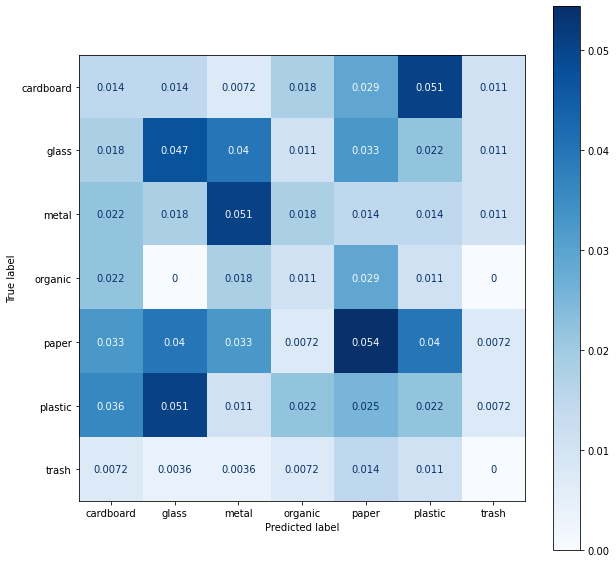

In [15]:
y = val_set.labels
y_pred = np.argmax(model.predict(val_set), axis=1)
evaluate(y, y_pred)

## Final Evaluation on Test set

### Classification Report and Confusion Matrix

5/5 [==============================] - 3s 535ms/step
              precision    recall  f1-score   support

   cardboard    0.81395   0.85366   0.83333        41
       glass    0.81481   0.86275   0.83810        51
       metal    0.79070   0.82927   0.80952        41
     organic    0.92308   0.92308   0.92308        26
       paper    0.81356   0.80000   0.80672        60
     plastic    0.87805   0.73469   0.80000        49
       trash    0.47059   0.53333   0.50000        15

    accuracy                        0.80919       283
   macro avg    0.78639   0.79097   0.78725       283
weighted avg    0.81358   0.80919   0.80991       283



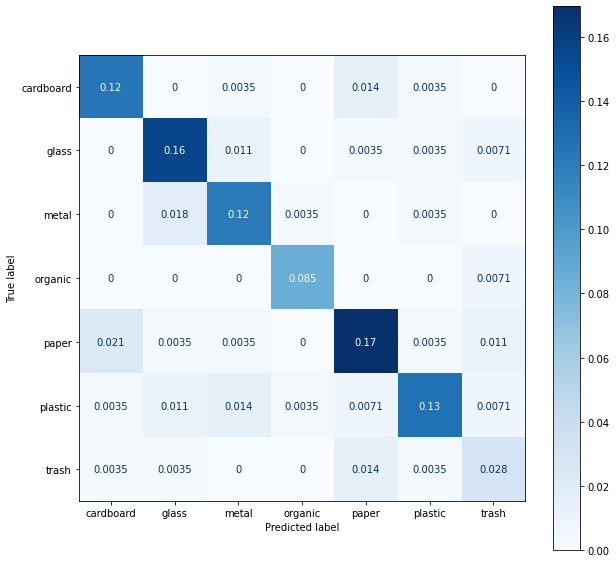

In [16]:
y = test_set.labels
y_pred = np.argmax(model.predict(test_set), axis=1)
evaluate(y, y_pred)

### Random Sample Test

In [17]:
def test():
    batch = np.random.randint(0, len(test_set)-1)
    data = 0
    img = np.random.randint(0, len(test_set[batch][data])-1)
    IMAG = test_set[batch][data][img]

    plt.imshow(IMAG)
    plt.show()
    pred = model.predict(IMAG.reshape(1, 128, 128, 3))
    probability = pred.max()
    index = np.argmax(pred)
    label = index_to_class.get(index)
    print(f"Model predicts {label.capitalize()} with probability {probability}")
    

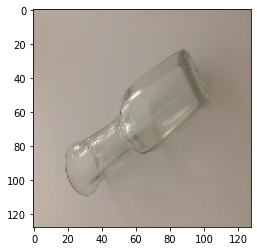

1/1 [==============================] - 1s 733ms/step
Model predicts Glass with probability 0.9496631026268005


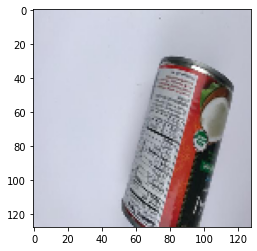

1/1 [==============================] - 0s 32ms/step
Model predicts Metal with probability 0.6820194125175476


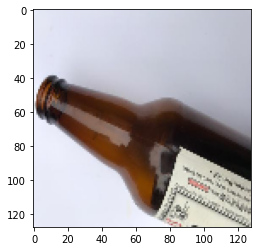

1/1 [==============================] - 0s 38ms/step
Model predicts Glass with probability 0.9886464476585388


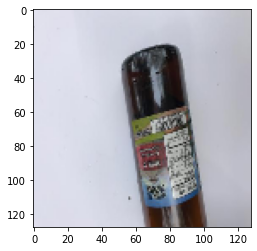

1/1 [==============================] - 0s 31ms/step
Model predicts Glass with probability 0.8960462808609009


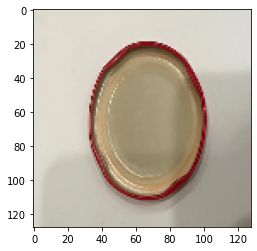

1/1 [==============================] - 0s 39ms/step
Model predicts Metal with probability 0.9647497534751892


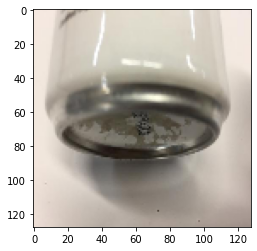

1/1 [==============================] - 0s 33ms/step
Model predicts Glass with probability 0.4203062355518341


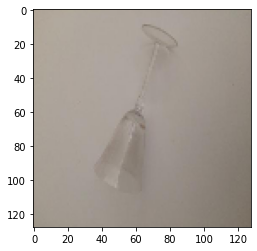

1/1 [==============================] - 0s 32ms/step
Model predicts Paper with probability 0.5025850534439087


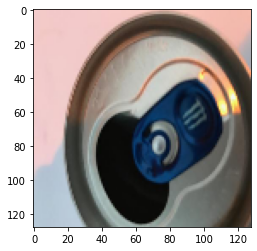

1/1 [==============================] - 0s 42ms/step
Model predicts Metal with probability 0.9828542470932007


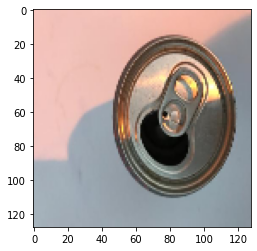

1/1 [==============================] - 0s 33ms/step
Model predicts Metal with probability 0.9991934895515442


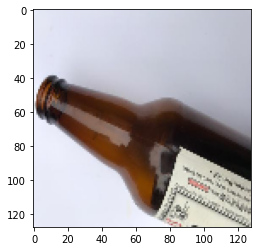

1/1 [==============================] - 0s 34ms/step
Model predicts Glass with probability 0.9886464476585388


In [18]:
for i in range(10):
    test()